<a href="https://colab.research.google.com/github/ItsnotMax/Kaggle/blob/main/Crab_Age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from google.colab import drive
drive.mount('/content/drive')

kaggle_token_path = '/content/drive/MyDrive/Kaggle/.kaggle'

! pip install kaggle --quiet
! pip install kaggle --upgrade
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Kaggle/.kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c playground-series-s3e16

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import BaggingRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

Mounted at /content/drive


In [2]:
path_to_files = '/content/drive/MyDrive/Kaggle/'
folder_name = 'CrabAge/'
X_dataframe = pd.read_csv (path_to_files + folder_name + 'train.csv')
for_predict = pd.read_csv (path_to_files + folder_name + 'test.csv')
correct_format = pd.read_csv (path_to_files + folder_name + 'sample_submission.csv')

In [9]:
X_dataframe.sample(10)

id Sex  Length  Diameter  Height     Weight  Shucked Weight  \
36021  36021   F  1.5375    1.2125  0.3750  31.269499       11.920965   
56438  56438   I  0.5875    0.4375  0.1250   1.913591        0.609514   
21737  21737   F  1.3000    1.0375  0.4500  25.160181       11.424848   
30504  30504   F  1.6000    1.2500  0.4750  38.427747       17.222321   
29386  29386   F  1.2500    0.9875  0.3125  16.031642        6.874754   
8513    8513   I  1.0875    0.8000  0.2250   9.681354        4.649318   
34695  34695   I  0.9125    0.6750  0.2000   5.556502        2.197086   
6745    6745   F  1.4000    1.0250  0.3125  24.139599       12.502130   
31296  31296   F  1.3625    1.0125  0.3750  22.438629       11.155528   
1381    1381   I  1.3125    1.0125  0.3000  18.597272        8.660772   

       Viscera Weight  Shell Weight  Age  
36021        6.180191     10.205820   17  
56438        0.581165      0.510291    4  
21737        6.860579      8.079607   14  
30504        8.660772     11.056305   11  
29386        3.983105      5.244657    8  
8513         1.771844      3.217668    8  
34695        1.063106      1.559222    6  
6745         5.627376      4.535920    9  
31296        4.734367      5.244657    9  
1381         3.486988      5.244657    9

          id Sex  Length  Diameter  Height     Weight  Shucked Weight  \
17839  17839   I  0.7375    0.5625  0.2125   3.005047        1.304077   
52686  52686   I  0.8750    0.6375  0.2000   5.060386        2.423882   
62595  62595   M  1.5000    1.1375  0.3500  30.560761       14.486595   
19311  19311   F  1.4000    1.1000  0.3625  27.130471       11.013781   
71276  71276   M  1.5750    1.2625  0.4000  35.819593       13.947954   
49902  49902   M  1.3750    1.0875  0.4000  22.977270        9.865626   
19622  19622   F  1.3000    1.0000  0.3625  24.706589        9.412034   
62297  62297   M  1.6125    1.2500  0.4500  37.109496       17.463292   
70930  70930   M  1.6375    1.2875  0.5250  41.390270       12.544654   
18221  18221   I  0.9875    0.7500  0.2375   8.901743        3.912231   

       Viscera Weight  Shell Weight  Age  
17839        0.751262      1.133980    6  
52686        0.864660      1.488349    5  
62595        5.910871      7.087375    8  
19311        6.095142   

<ipython-input-10-d00b8114e88b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print (X_dataframe.corr())


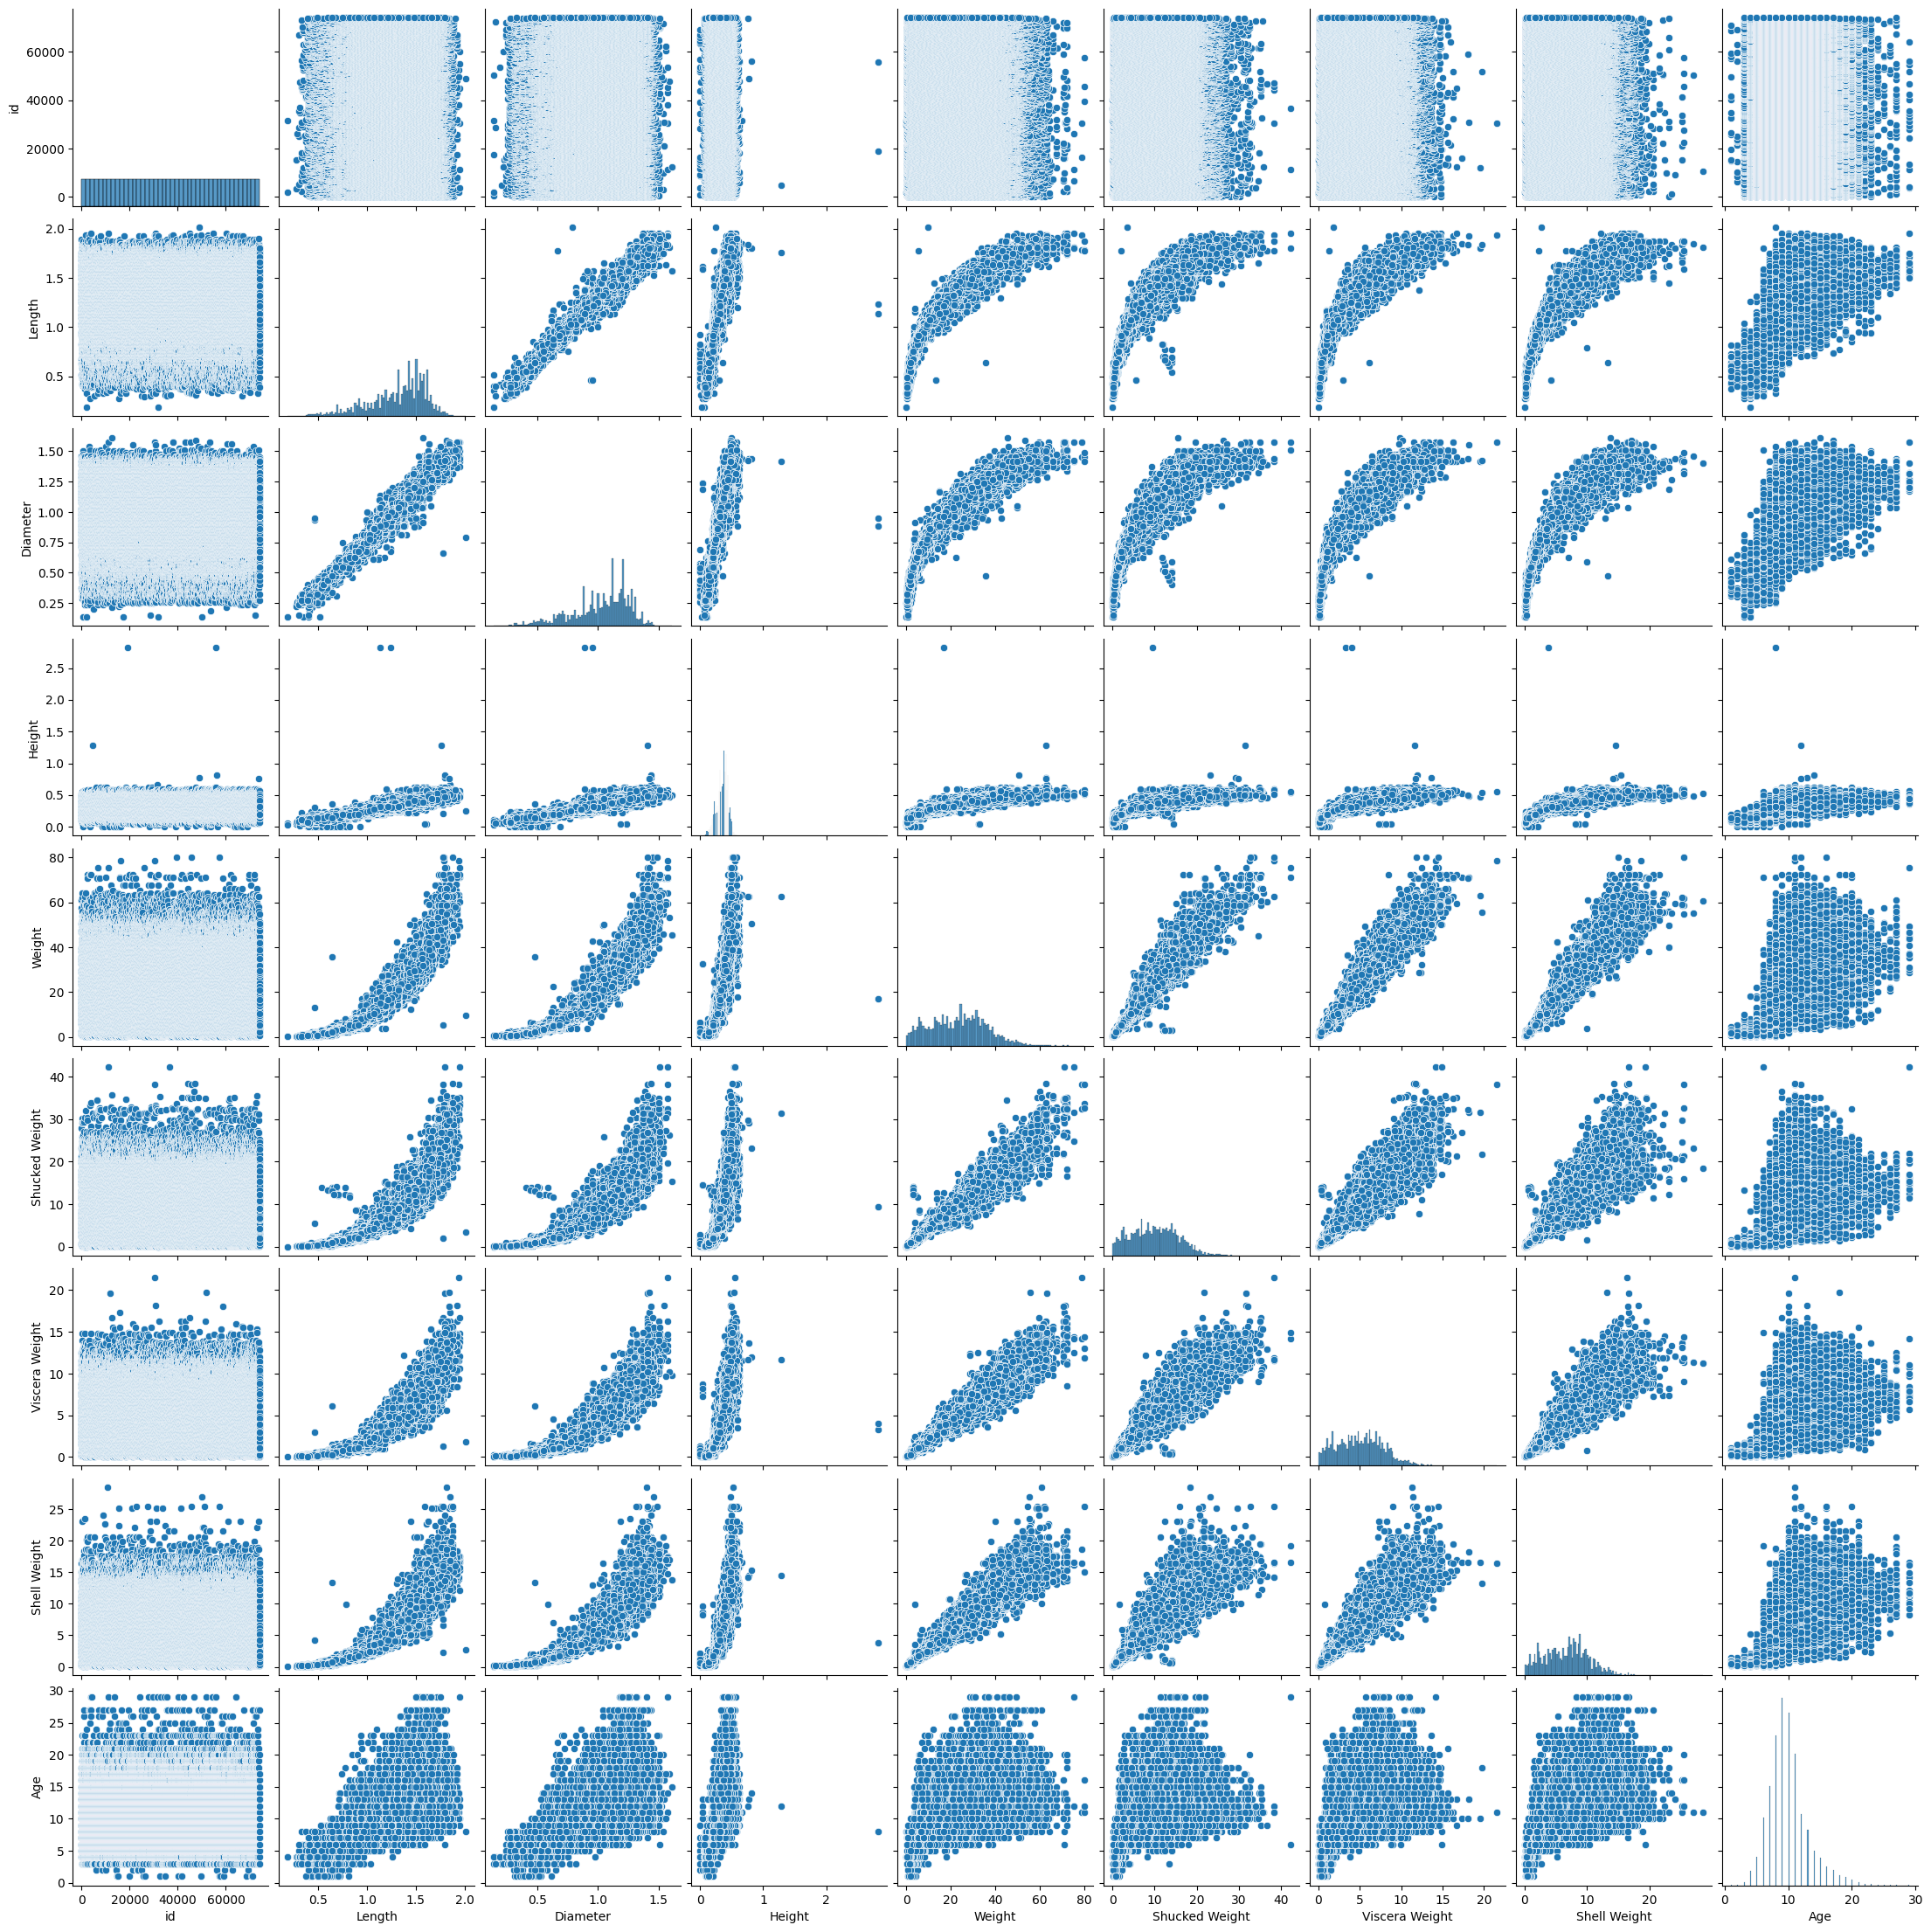

In [10]:
print (X_dataframe.sample(10))
print (X_dataframe.corr())
sns.pairplot(X_dataframe)

In [26]:
y = X_dataframe['Age']
X = X_dataframe.drop (columns = ['id', 'Age', 'Sex'])

def new_feature (X = X):
  X['Viscera/Diameter'] = X['Viscera Weight'] / X['Diameter']
  X['logWeight'] = np.log(X['Weight'] + 1)
  X['logDiam'] = np.log(X['Diameter'] + 1)
  X['logViscDiam'] = np.log(X['Viscera/Diameter']+1)
  X['Square'] = np.pi * (X['Diameter']/2)**2
  X['Square/logDiam'] = X['Square'] / X['logDiam']
  X['Surface_Area'] = 2 * ((X['Length'] * X['Diameter']) + (X['Length'] * X['Height']) + (X['Diameter'] * X['Height']))
  X['Volume'] = X['Length'] * X['Diameter'] * X['Height']
  X = X.drop(columns = ['Height'])
  return X

X = new_feature().dropna()

def quantile_X (X=X, y=y):
  begin =  [np.quantile (X[col], 0.03) for col in X.columns]
  end =  [np.quantile (X[col], 0.97) for col in X.columns]
  for idx, col in enumerate (X.columns):
    X = X[(X[col]<=end[idx]) & (X[col]>=begin[idx])]
  indices = X.index.to_list ()
  y = y.loc[indices]
  step_float = 0.005
  X = np.round (X.select_dtypes(include = ['float', 'int']) - (X.select_dtypes(include = ['float', 'int'])%step_float), 3)
  return X, y

X_q, y = quantile_X()

X_train, X_test, y_train, y_test = train_test_split(X_q, y, test_size=0.2, shuffle=True)
X.corr()

Length  Diameter    Weight  Shucked Weight  \
Length            1.000000  0.989437  0.936374        0.915516   
Diameter          0.989437  1.000000  0.938249        0.914199   
Weight            0.936374  0.938249  1.000000        0.971267   
Shucked Weight    0.915516  0.914199  0.971267        1.000000   
Viscera Weight    0.917855  0.918351  0.971062        0.942626   
Shell Weight      0.916957  0.922688  0.965525        0.910398   
Viscera/Diameter  0.914327  0.907892  0.942529        0.913260   
logWeight         0.981980  0.981277  0.923533        0.897930   
logDiam           0.987729  0.996773  0.915089        0.891620   
logViscDiam       0.947614  0.941504  0.909182        0.881714   
Square            0.974422  0.987822  0.966584        0.941856   
Square/logDiam    0.986341  0.998063  0.952291        0.927899   
Surface_Area      0.978981  0.981024  0.972949        0.945769   
Volume            0.936365  0.940077  0.974148        0.943138   

                  Viscera Weight  Shell Weight  Viscera/Diameter  logWeight  \
Length                  0.917855      0.916957          0.914327   0.981980   
Diameter                0.918351      0.922688          0.907892   0.981277   
Weight                  0.971062      0.965525          0.942529   0.923533   
Shucked Weight          0.942626      0.910398          0.913260   0.897930   
Viscera Weight          1.000000      0.933919          0.986549   0.900734   
Shell Weight            0.933919      1.000000          0.905515   0.903791   
Viscera/Diameter        0.986549      0.905515          1.000000   0.914384   
logWeight               0.900734      0.903791          0.914384   1.000000   
logDiam                 0.895906      0.901572          0.894770   0.987039   
logViscDiam             0.938917      0.882676          0.971669   0.963890   
Square                  0.945520      0.947132          0.916469   0.951864   
Square/logDiam          0.931879      0.935143          0.914001   0.972398   
Surface_Area            0.952534      0.955899          0.929009   0.955087   
Volume                  0.952930      0.958618          0.915806   0.905073   

                   logDiam  logViscDiam    Square  Square/logDiam  \
Length            0.987729     0.947614  0.974422        0.986341   
Diameter          0.996773     0.941504  0.987822        0.998063   
Weight            0.915089     0.909182  0.966584        0.952291   
Shucked Weight    0.891620     0.881714  0.941856        0.927899   
Viscera Weight    0.895906     0.938917  0.945520        0.931879   
Shell Weight      0.901572     0.882676  0.947132        0.935143   
Viscera/Diameter  0.894770     0.971669  0.916469        0.914001   
logWeight         0.987039     0.963890  0.951864        0.972398   
logDiam           1.000000     0.943714  0.972232        0.989872   
logViscDiam       0.943714     1.000000  0.919428        0.935466   
Square            0.972232     0.919428  1.000000        0.995585   
Square/logDiam    0.989872     0.935466  0.995585        1.000000   
Surface_Area      0.965997     0.928576  0.992161        0.988357   
Volume            0.915785     0.887326  0.970655        0.955016   

                  Surface_Area    Volume  
Length                0.978981  0.936365  
Diameter              0.981024  0.940077  
Weight                0.972949  0.974148  
Shucked Weight        0.945769  0.943138  
Viscera Weight        0.952534  0.952930  
Shell Weight          0.955899  0.958618  
Viscera/Diameter      0.929009  0.915806  
logWeight             0.955087  0.905073  
logDiam               0.965997  0.915785  
logViscDiam           0.928576  0.887326  
Square                0.992161  0.970655  
Square/logDiam        0.988357  0.955016  
Surface_Area          1.000000  0.986761  
Volume                0.986761  1.000000

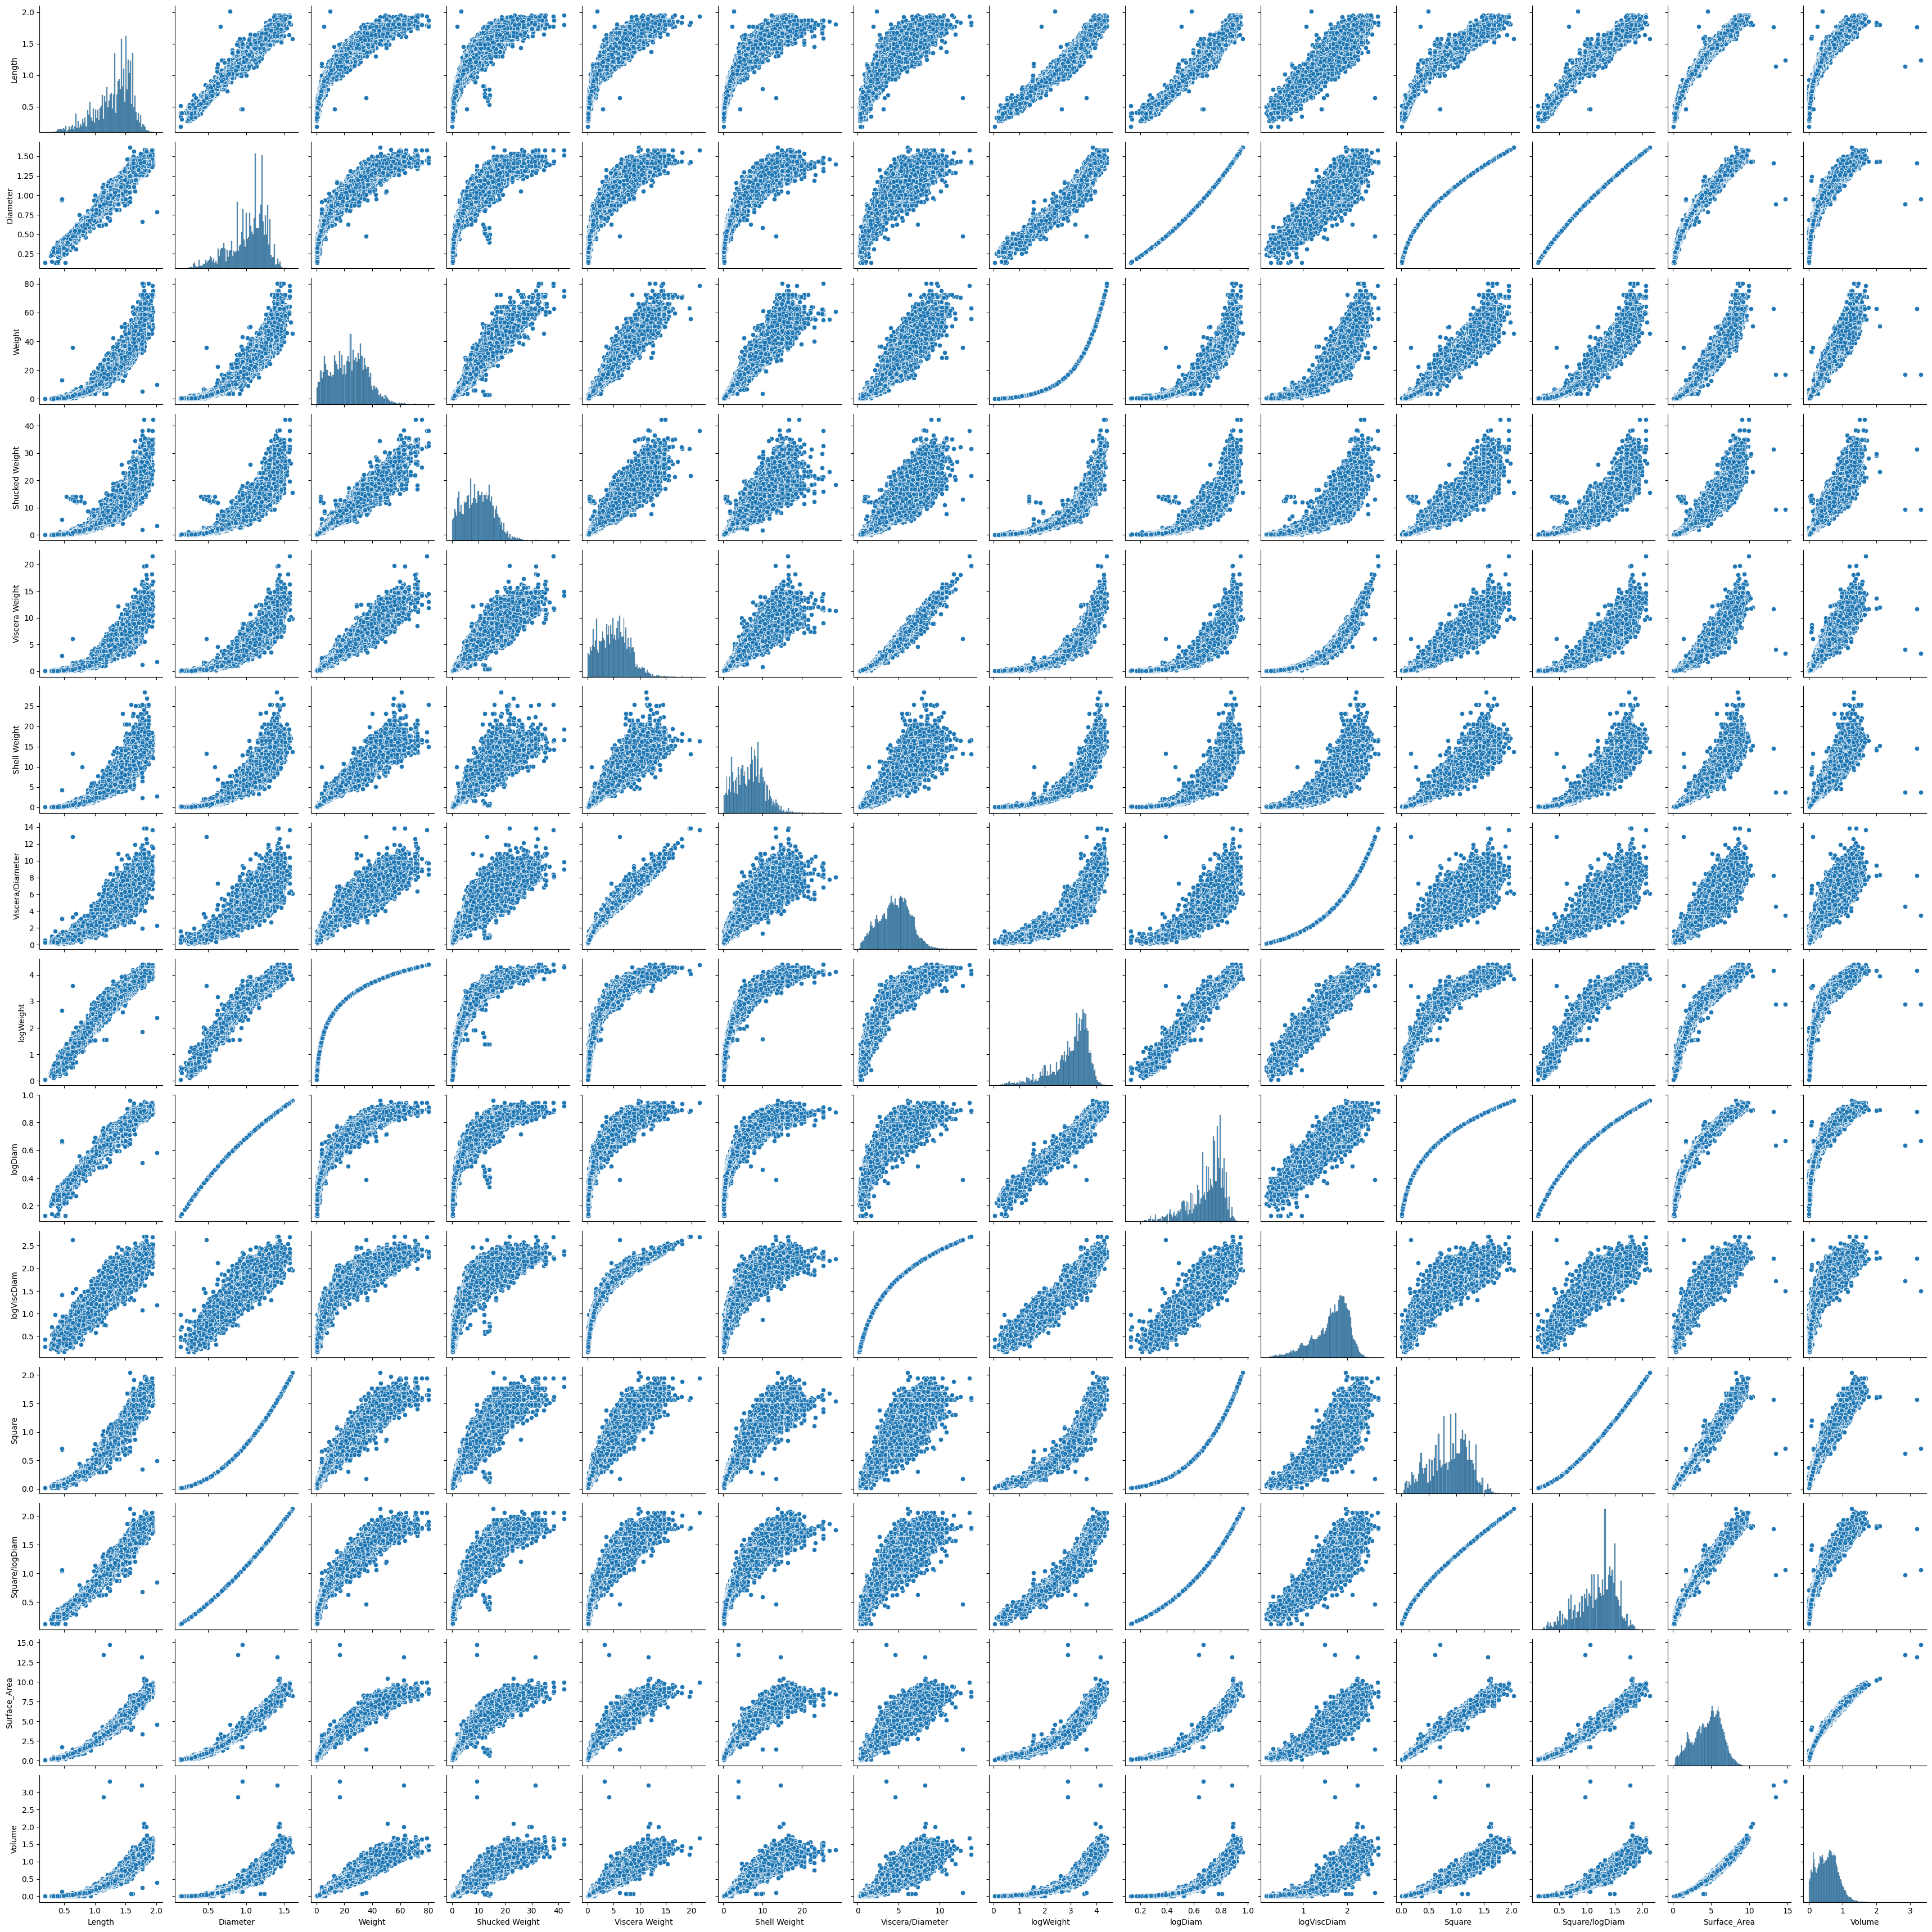

In [23]:
sns.pairplot(X)

In [28]:
lgbm = LGBMRegressor(objective='mae')

lgbm_params =  {
    'num_leaves': range (40, 100, 2),
    'max_depth': range (1,15),
    'learning_rate': np.arange (0.001, 1, 0.005),
    'n_estimators': range (300, 700, 10),
    'subsample': np.arange (0.1, 1, 0.05),
    'colsample_bytree': np.arange (0.01, 1, 0.05),
    'reg_alpha': np.arange (0.01, 1, 0.05),
    'min_child_samples': range (40, 100, 2)
    }

randomized_lgbm = RandomizedSearchCV(lgbm, param_distributions = lgbm_params,
                        scoring = 'neg_mean_absolute_error',
                        cv = 3,
                        n_jobs = -1,
                        return_train_score = True,
                        n_iter=60
                        )

lgbm_bag = BaggingRegressor (estimator=randomized_lgbm, n_estimators=6).fit(X_q, y)
print (mean_absolute_error (y_test, lgbm_bag.predict (X_test)))

1.1882200112022527


In [29]:
df_for_pred = new_feature (for_predict)
df_for_pred = df_for_pred.drop (columns = ['id', 'Sex'])

output = lgbm_bag.predict (df_for_pred)

solution = pd.DataFrame ({
    'id': for_predict['id'],
    'Age': np.round (output, 0)
    })

solution.to_csv('solution.csv', index=False)
! kaggle competitions submit -c playground-series-s3e16 -f solution.csv -m '_'

100% 531k/531k [00:00<00:00, 853kB/s]
Successfully submitted to Regression with a Crab Age Dataset